# Introduction

In [ ]:
root = '../..'

# Importing Libraries and Data

In [ ]:
# generel utility libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from utils import show_example, plot_training_history
from IPython.display import clear_output

# keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# keras tuner
!pip install keras-tuner
clear_output()
from keras_tuner import HyperModel, RandomSearch

# function to read matlab data file
from scipy.io import loadmat

In [3]:
X = loadmat(os.path.join(root, 'data/mnist_training_data.mat'))['training_data']
y = loadmat(os.path.join(root, 'data/mnist_training_label.mat'))['training_label']

X_test = loadmat(os.path.join(root, 'data/mnist_test_data.mat'))['test_data']
y_test = loadmat(os.path.join(root, 'data/mnist_test_label.mat'))['test_label']

train_size, n_features = X.shape
test_size, _ = X_test.shape
seed = 0

shuffled_indices = np.random.permutation(train_size)
X = X[shuffled_indices]
y = y[shuffled_indices]

print(f"No. of features:\t\t{n_features}")
print(f"No. of training examples:\t{train_size}")
print(f"No. of test examples:\t\t{test_size}")

No. of features:		784
No. of training examples:	50000
No. of test examples:		10000


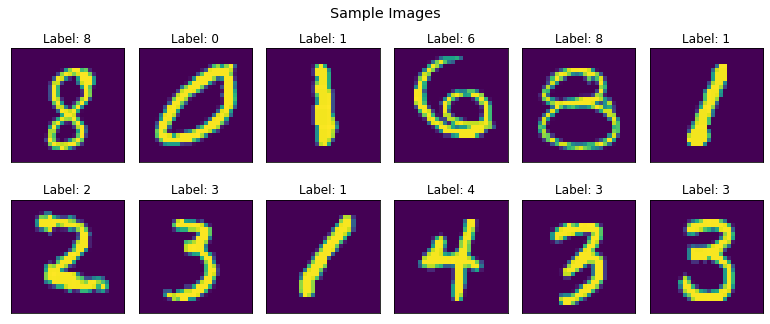

In [4]:
show_example(X, y)

# Configuring GPU

In [5]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f"No. of GPUs available: {len(physical_devices)}")
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

No. of GPUs available: 1


# Selecting Model Architecture by Cross-validation

We select number of hidden layers and number of units in each layers by cross validation. We chose to vary number of hidden layers from 1 to 10 and for each number of layers we search for the optimum number of hidden units in each layer. The number of units in each hidden layer are chosen from the set $\{16i : i=1(1)32\}$. We take the model resulting the minimum validation loss for each number of layers.

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = [*sss.split(X, y)][0]

X_train, X_val = X[train_idx, :], X[val_idx, :]
y_train, y_val = y[train_idx, :], y[val_idx, :]

## Building Hypermodel and Searching for the Best Model 

In [7]:
class MyHyperModel(HyperModel):
    def __init__(self, classes, layers):
        self.classes = classes
        self.layers = layers

    def build(self, hp):
        # Build Model
        model = keras.Sequential()
        for i in range(self.layers):
            model.add(layers.Dense(
                units=hp.Choice(
                    f"layer_{i+1:02}", 
                    values=list(range(16, 513, 16))
                ),
                kernel_initializer='he_uniform',
                activation='relu'
            ))
        model.add(layers.Dense(self.classes, activation='softmax'))
        
        # Compile Model
        model.compile(
            optimizer=keras.optimizers.Adam(0.001),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

In [8]:
params = {}
for i in range(10):
    print(f"Number of Hidden Layers: {i+1}")
    hypermodel = MyHyperModel(10, i+1)

    tuner = RandomSearch(
        hypermodel,
        objective='val_loss',
        max_trials=20,
        overwrite=True
    )

    es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    tuner.search(
        X_train, y_train, validation_data=(X_val, y_val),
        epochs=500, batch_size=10000, verbose=1 , callbacks=[es]
    )
    params[i+1] = tuner.get_best_hyperparameters()[0].values

Trial 20 Complete [00h 00m 11s]
val_loss: 0.12028399854898453

Best val_loss So Far: 0.10062313079833984
Total elapsed time: 00h 03m 41s
INFO:tensorflow:Oracle triggered exit


## Creating Models from the Best Model Architectures

In [9]:
def create_model(input_size, num_units):
    model = Sequential()
    model.add(layers.InputLayer(input_size))
    for units in num_units.values():
        model.add(layers.Dense(
            units, 
            activation='relu', 
            kernel_initializer='he_uniform'
        ))
    model.add(layers.Dense(10, activation='softmax'))
    return model

models = []
for num_units in params.values():
    model = create_model(n_features, num_units)
    models.append(model)

In [10]:
for model in models:
    print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 464)               364240    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                29760     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 394,650

## Training the Models

In [11]:
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    mode='auto', 
    patience=20, 
    verbose=1, 
    restore_best_weights=True
)

In [12]:
metrics = pd.DataFrame(columns=['n_layers', 'train_loss', 'train_acc', 
                                'val_loss', 'val_acc'])

if not os.path.isdir('./models'):
    os.makedirs('./models')
for i, model in enumerate(models):

    # Saving initial model weights
    model.save_weights(f'./models/model_{i+1}.h5')
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train_idx, valid_idx in skf.split(X, y):
        print(f"Training Model {i+1}:")

        # Reseting Model
        model.load_weights(f'./models/model_{i+1}.h5')
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )

        # Setting up training and validation data
        X_train, X_valid = X[train_idx, :], X[valid_idx, :]
        y_train, y_valid = y[train_idx, :], y[valid_idx, :]

        # training the model
        training_history = model.fit(
            X_train, y_train, validation_data=(X_valid, y_valid),
            epochs=500, batch_size=10000,
            shuffle=True, verbose=1, callbacks=[es]
        )
        clear_output()

        # Get and store acurracies and losses
        train_loss, train_acc = model.evaluate(X_train, y_train)
        valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
        clear_output()

        metrics = metrics.append(dict(
            n_layers=len(model.layers) - 1,
            train_loss=train_loss,
            train_acc=train_acc,
            val_loss=valid_loss,
            val_acc=valid_acc
        ), ignore_index=True)

The training and validation accuracies and losses are stored in `metrics` for each number of layers for each cross-validation split. We take the average of each metric to compare the performace for each number of layers.

In [13]:
results = metrics.groupby('n_layers').aggregate(np.mean)
num_layers = results['val_loss'].idxmin().astype('int')
results

,train_loss,train_acc,val_loss,val_acc
n_layers,,,,
1.0,0.009928,0.999485,0.085419,0.97566
2.0,0.013499,0.998615,0.088526,0.97472
3.0,0.013726,0.998280,0.092773,0.97418
4.0,0.015035,0.997625,0.093773,0.97348
5.0,0.018108,0.996730,0.096806,0.97274
6.0,0.012801,0.997960,0.099219,0.97258
7.0,0.020594,0.995350,0.099704,0.97238
8.0,0.024805,0.994385,0.105647,0.97066
9.0,0.030902,0.992310,0.116853,0.96740


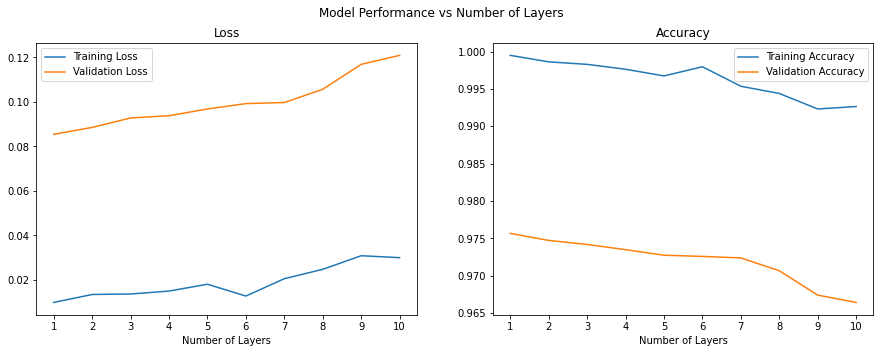

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Model Performance vs Number of Layers")
fig.set_size_inches(15, 5)

ax1.plot(results['train_loss'], label='Training Loss')
ax1.plot(results['val_loss'], label='Validation Loss')
ax1.set_xlabel('Number of Layers')
ax1.set_xticks(results.index)
ax1.set_title('Loss')
ax1.legend()

ax2.plot(results['train_acc'], label='Training Accuracy')
ax2.plot(results['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Number of Layers')
ax2.set_xticks(results.index)
ax2.set_title('Accuracy')
ax2.legend()

fig.show()

We have plotted the metrics for each number of layers. From the figure it is apparent that validation loss is minimum with one hidden layer. The number of units for which validation loss is minimum is 512.

# Picking Best Model Architecture

Next we create the model with the best scoring architecture and load the initial weights and optimizers.

In [15]:
model = models[num_layers - 1]
model.load_weights(f'./models/model_{num_layers}.h5')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


# Training the Best Model

In [17]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = [*sss.split(X, y)][0]

X_train, X_val = X[train_idx, :], X[val_idx, :]
y_train, y_val = y[train_idx, :], y[val_idx, :]

In [18]:
training_history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=500, batch_size=10000, shuffle=True,
    verbose=1, callbacks=[es]
)

Epoch 1/500
5/5 [==============================] - 1s 56ms/step - loss: 1.9718 - accuracy: 0.3784 - val_loss: 1.2889 - val_accuracy: 0.7408
Epoch 2/500
5/5 [==============================] - 0s 27ms/step - loss: 1.0427 - accuracy: 0.7914 - val_loss: 0.7450 - val_accuracy: 0.8192
Epoch 3/500
5/5 [==============================] - 0s 26ms/step - loss: 0.6391 - accuracy: 0.8396 - val_loss: 0.5305 - val_accuracy: 0.8514
Epoch 4/500
5/5 [==============================] - 0s 26ms/step - loss: 0.4740 - accuracy: 0.8720 - val_loss: 0.4381 - val_accuracy: 0.8720
Epoch 5/500
5/5 [==============================] - 0s 27ms/step - loss: 0.3983 - accuracy: 0.8885 - val_loss: 0.3856 - val_accuracy: 0.8910
Epoch 6/500
5/5 [==============================] - 0s 25ms/step - loss: 0.3537 - accuracy: 0.8982 - val_loss: 0.3509 - val_accuracy: 0.9004
Epoch 7/500
5/5 [==============================] - 0s 27ms/step - loss: 0.3224 - accuracy: 0.9068 - val_loss: 0.3238 - val_accuracy: 0.9078
Epoch 8/500
5/5 [===

# Training History and Model Performace

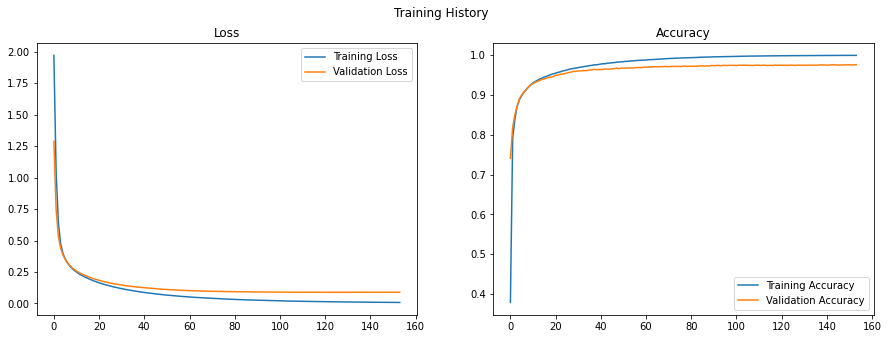

In [19]:
plot_training_history(training_history)

In [20]:
nn_train_loss, nn_train_acc = model.evaluate(X_train, y_train, verbose=0)
nn_test_loss,  nn_test_acc  = model.evaluate(X_test,  y_test,  verbose=0)

print(f"Training Accuracy: {nn_train_acc:2.2%}")
print(f"Test Accuracy:     {nn_test_acc :2.2%}")
print(f"Training Loss: {nn_train_loss:.6}")
print(f"Test Loss:     {nn_test_loss :.6}")

Training Accuracy: 99.93%
Test Accuracy:     97.79%
Training Loss: 0.0106768
Test Loss:     0.0724103


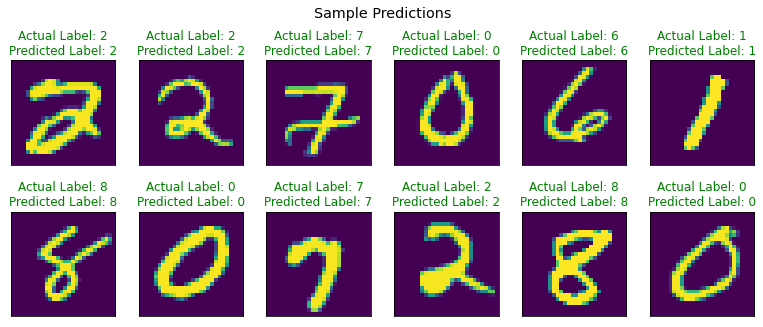

In [21]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
show_example(X_test, y_test, y_pred)

# Saving Trained Model

In [22]:
model.save(os.path.join(root, 'models/nn_unrotated_model_wo_pca'))

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/MNIST-classification/models/final_model_wo_pca/assets


# Training Model with Dimension Reduction

The previous model was built with all the features taken into account. But there may be some features (in this case pixels) that varies less than some other features. Those features not only less useful in training the classifier but also works as noise that may hinder the model performance. To check if there actually is some feature like that we plot the standard daviation for each feature.

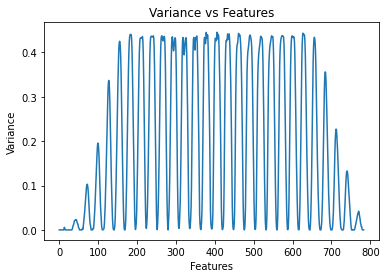

In [23]:
plt.plot(np.std(X, axis=0))
plt.title('Variance vs Features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.show()

It is apparent from the figure that some features (or pixels) have very small standard daviation compared to some others. A possible reason may be that the corner or edge pixels have less importance than the pixels in the middle to explain the subject. We apply PCA algorithm to filter out features so that 90% variablity is retained.

In [24]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

# Applying Variance Threshold
# sel = VarianceThreshold(threshold=0.1)
sel = PCA(0.90)
Z = sel.fit_transform(X)
Z_test = sel.transform(X_test)

train_size, n_features = Z.shape
test_size, _ = Z_test.shape

shuffled_indices = np.random.permutation(train_size)
Z = Z[shuffled_indices]
y = y[shuffled_indices]

print(f"No. of features:\t\t{n_features}")
print(f"No. of training examples:\t{train_size}")
print(f"No. of test examples:\t\t{test_size}")

No. of features:		88
No. of training examples:	50000
No. of test examples:		10000


As we can see the number of features is drastically reduced from 784 to 88 with 90% variablity still retained.

# Selecting Model Architecture by Cross-validation (with Dimension Reduction)

We again select the model architecture in the previous manner which will be best suited for the data with lower number of feature.

In [25]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = [*sss.split(Z, y)][0]

Z_train, Z_val = Z[train_idx, :], Z[val_idx, :]
y_train, y_val = y[train_idx, :], y[val_idx, :]

## Searching for the Best Model

In [26]:
params = {}
for i in range(10):
    print(f"Number of Hidden Layers: {i+1}")
    hypermodel = MyHyperModel(10, i+1)

    tuner = RandomSearch(
        hypermodel,
        objective='val_loss',
        max_trials=20,
        overwrite=True
    )

    es = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    tuner.search(
        Z_train, y_train, validation_data=(Z_val, y_val),
        epochs=500, batch_size=10000, verbose=1, callbacks=[es]
    )
    params[i+1] = tuner.get_best_hyperparameters()[0].values

Trial 20 Complete [00h 00m 12s]
val_loss: 0.12540292739868164

Best val_loss So Far: 0.10264710336923599
Total elapsed time: 00h 02m 58s
INFO:tensorflow:Oracle triggered exit


## Creating Models from the Best Model Architecture

In [27]:
models = []
for num_units in params.values():
    model = create_model(n_features, num_units)
    models.append(model)

In [28]:
for model in models:
    print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 448)               39872     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                4490      
Total params: 44,362
Trainable params: 44,362
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 464)               41296     
_________________________________________________________________
dense_14 (Dense)             (None, 480)               223200    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                4810      
Total params: 269,306
T

## Training the Models

In [29]:
metrics = pd.DataFrame(columns=['n_layers', 'train_loss', 'train_acc', 
                                'val_loss', 'val_acc'])

if not os.path.isdir('./models'):
    os.makedirs('./models')
for i, model in enumerate(models):

    # Saving initial model weights
    model.save_weights(f'./models/model_{i+1}.h5')
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for train_idx, valid_idx in skf.split(Z, y):
        print(f"Training Model {i+1}:")

        # Reseting Model
        model.load_weights(f'./models/model_{i+1}.h5')
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001), 
            loss='sparse_categorical_crossentropy', 
            metrics=['accuracy']
        )

        # Setting up training and validation data
        Z_train, Z_valid = Z[train_idx, :], Z[valid_idx, :]
        y_train, y_valid = y[train_idx, :], y[valid_idx, :]

        # training the model
        training_history = model.fit(
            Z_train, y_train, validation_data=(Z_valid, y_valid),
            epochs=500, batch_size=10000,
            shuffle=True, verbose=1, callbacks=[es]
        )
        clear_output()

        # Get and store acurracies and losses
        train_loss, train_acc = model.evaluate(Z_train, y_train)
        valid_loss, valid_acc = model.evaluate(Z_valid, y_valid)
        clear_output()

        metrics = metrics.append(dict(
            n_layers=len(model.layers) - 1,
            train_loss=train_loss,
            train_acc=train_acc,
            val_loss=valid_loss,
            val_acc=valid_acc
        ), ignore_index=True)

The training and validation accuracies and losses are again stored in `metrics` for each number of layers for each cross-validation split. We take the average of each metric to compare the performace for each number of layers.

In [30]:
results = metrics.groupby('n_layers').aggregate(np.mean)
num_layers = results['val_loss'].idxmin().astype('int')
results

,train_loss,train_acc,val_loss,val_acc
n_layers,,,,
1.0,0.007656,0.999870,0.079683,0.97642
2.0,0.008239,0.999710,0.080706,0.97666
3.0,0.012096,0.999055,0.088590,0.97402
4.0,0.012157,0.998850,0.091144,0.97390
5.0,0.015891,0.997875,0.102336,0.97036
6.0,0.016433,0.997445,0.100104,0.97180
7.0,0.016820,0.996995,0.101890,0.97138
8.0,0.023952,0.995240,0.116274,0.96752
9.0,0.028458,0.993465,0.118166,0.96610


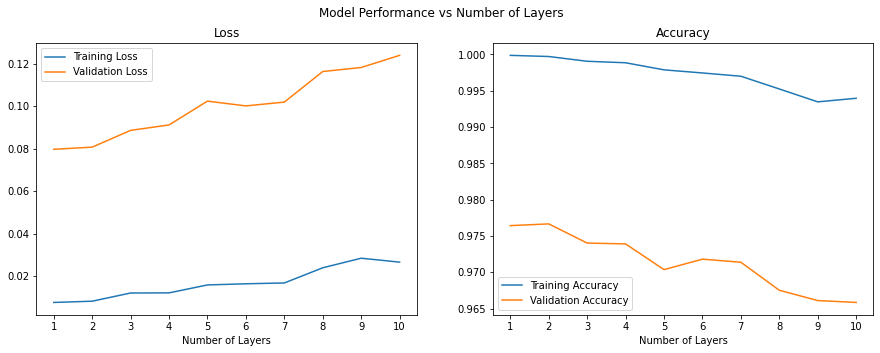

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Model Performance vs Number of Layers")
fig.set_size_inches(15, 5)

ax1.plot(results['train_loss'], label='Training Loss')
ax1.plot(results['val_loss'], label='Validation Loss')
ax1.set_xlabel('Number of Layers')
ax1.set_xticks(results.index)
ax1.set_title('Loss')
ax1.legend()

ax2.plot(results['train_acc'], label='Training Accuracy')
ax2.plot(results['val_acc'], label='Validation Accuracy')
ax2.set_xlabel('Number of Layers')
ax2.set_xticks(results.index)
ax2.set_title('Accuracy')
ax2.legend()

fig.show()

We have plotted the metrics for each number of layers. From the figure it is apparent that validation loss is minimum with one hidden layer. The number of units for which validation loss is minimum is 448.

# Picking Best Model Architecture (with Dimension Reduction)

Next we create the model with the best scoring architecture and load the initial weights and optimizers.

In [32]:
model = models[num_layers - 1]
model.load_weights(f'./models/model_{num_layers}.h5')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 448)               39872     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                4490      
Total params: 44,362
Trainable params: 44,362
Non-trainable params: 0
_________________________________________________________________


# Training the Best Model (with Dimension Reduction)

In [34]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=seed)
train_idx, val_idx = [*sss.split(Z, y)][0]

Z_train, Z_val = Z[train_idx, :], Z[val_idx, :]
y_train, y_val = y[train_idx, :], y[val_idx, :]

In [35]:
training_history = model.fit(
    Z_train, y_train, validation_data=(Z_val, y_val),
    epochs=500, batch_size=10000, shuffle=True,
    verbose=1, callbacks=[es]
)

Epoch 1/500
5/5 [==============================] - 0s 37ms/step - loss: 2.3692 - accuracy: 0.1794 - val_loss: 1.8928 - val_accuracy: 0.3562
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 1.6904 - accuracy: 0.4541 - val_loss: 1.3562 - val_accuracy: 0.6170
Epoch 3/500
5/5 [==============================] - 0s 10ms/step - loss: 1.2179 - accuracy: 0.6755 - val_loss: 0.9941 - val_accuracy: 0.7480
Epoch 4/500
5/5 [==============================] - 0s 10ms/step - loss: 0.9054 - accuracy: 0.7830 - val_loss: 0.7642 - val_accuracy: 0.8224
Epoch 5/500
5/5 [==============================] - 0s 12ms/step - loss: 0.7103 - accuracy: 0.8351 - val_loss: 0.6219 - val_accuracy: 0.8538
Epoch 6/500
5/5 [==============================] - 0s 10ms/step - loss: 0.5892 - accuracy: 0.8615 - val_loss: 0.5297 - val_accuracy: 0.8718
Epoch 7/500
5/5 [==============================] - 0s 10ms/step - loss: 0.5094 - accuracy: 0.8771 - val_loss: 0.4668 - val_accuracy: 0.8856
Epoch 8/500
5/5 [===

# Training History and Model Performace (with Dimension Reduction)

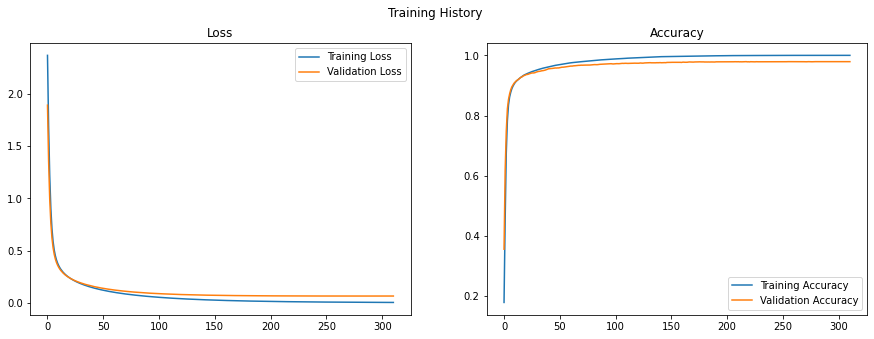

In [36]:
plot_training_history(training_history)

In [37]:
nn_train_loss, nn_train_acc = model.evaluate(Z_train, y_train, verbose=0)
nn_test_loss,  nn_test_acc  = model.evaluate(Z_test,  y_test,  verbose=0)

print(f"Training Accuracy: {nn_train_acc:2.2%}")
print(f"Test Accuracy:     {nn_test_acc :2.2%}")
print(f"Training Loss: {nn_train_loss:.6}")
print(f"Test Loss:     {nn_test_loss :.6}")

Training Accuracy: 99.99%
Test Accuracy:     97.90%
Training Loss: 0.00597742
Test Loss:     0.066724


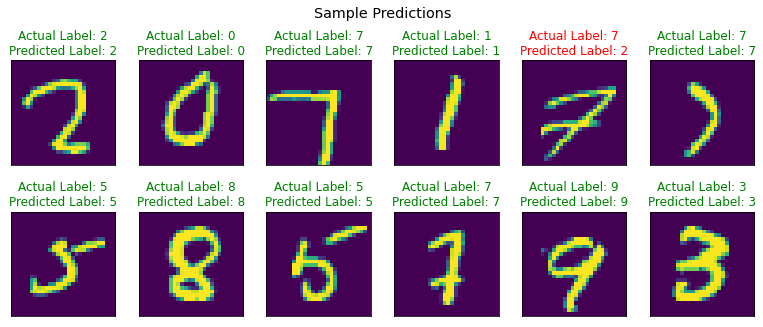

In [38]:
y_pred = np.argmax(model.predict(Z_test), axis=-1)
show_example(X_test, y_test, y_pred)

# Saving Trained Model (with Dimension Reduction)

In [39]:
model.save(os.path.join(root, 'models/nn_unrotated_model_w_pca'))

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/MNIST-classification/models/final_model_w_pca/assets


# Conclusion

|           |Training Accuracy|Test Accuracy|
|:---------:|:---------------:|:-----------:|
|Without PCA|      99.93%     |    97.79%   |
|With PCA   |      99.99%     |    97.90%   |

Clearly the accuracy is increased by applying PCA with 90% variability retained but the increase is not much significant.